<a href="https://colab.research.google.com/github/flying-bear/infosearch/blob/master/sem4_ML_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа
## Ранжирование с помощью ML


![](https://avatars.mds.yandex.net/get-research/1677227/2a00000168a82fc9b0eac19e430b8454a656/orig)


Одна из отличительных особенностей задачи ранжирования от классических задач машинного обучения заключается в том, что качество результата зависит не от предсказанных оценок релевантности, а от порядка следования документов в рамках конкретного запроса, т.е. важно не абсолютное значение релевантности (его достаточно трудно формализовать в виде числа), а то, более или менее релевантен документ, относительно других документов.

### Подходы к решению задачи ранжирования
Существуют 3 основных подхода к ранжированию, различие между которыми заключается в том, на какую функцию потерь они опираются:
  
1. **Поточечный подход (pointwise)**. В этом подходе предполагается, что каждой паре запрос-документ поставлена в соответствие численная оценка. Задача обучения ранжированию сводится к построению регрессии: для каждой отдельной пары запрос-документ необходимо предсказать её оценку.

2. **Попарный подход (pairwise)**. В таком подходе обучение ранжированию сводится к построению бинарного классификатора, которому на вход поступают два документа, соответствующих одному и тому же запросу, и требуется определить, какой из них лучше. Другими словами, функция потерь штрафует модель, если отранжированная этой моделью пара документов оказалась в неправильном порядке.

3. **Списочный подход (listwise)**. Его суть заключается в построении модели, на вход которой поступают сразу все документы, соответствующие запросу, а на выходе получается их перестановка.


Будем использовать самый простой подход - поточечный.

### Оценка качества

Для оценивания качества ранжирования найденных документов в поиске традиционно используется метрика *DCG* ([Discounted Cumulative Gain](https://en.wikipedia.org/wiki/Discounted_cumulative_gain)) и ее нормализованный вариант — *nDCG*, всегда принимающий значения от 0 до 1.

Для одного запроса DCG считается следующим образом:
$$ DCG(Q) = \sum_{i=1}^{numpos}\frac{(2^{rel_i} - 1)}{\log_2(i+1)}, $$
где
>$numpos$ — количество документов в поисковой выдаче, среди которых мы оценимваем качество (например, в предудыщих заданиях *num_pos* был равен 5)  
$rel_i$ — оценка релевантности документа, находящегося на i-той позиции   
   

Нормализованный вариант *nDCG* получается делением *DCG* на максимальное из его значений:

$$nDCG = \frac{DCG}{IDCG} \in [0, 1].$$
> *IDCG* — наибольшее из возможных значение *DCG* 






Чтобы оценить значение *nDCG* на выборке $Queries$ ($nDCG_{Queries}$) размера $N$, необходимо усреднить значение *nDCG* по всем запросам  выборки:
$$nDCG_{Queries} = \frac{1}{N}\sum_{q \in Queries}nDCG(q).$$

Пример реализации метрик ранжирование на python можно найти [здесь](https://gist.github.com/mblondel/7337391).

# Погнали
###  **Задача: предсказать оценку релевантности для запросов тестового датасета**


Мы будем работать на данных с конкурса [Интернет-математика 2009](https://academy.yandex.ru/events/data_analysis/grant2009/). По ссылке можно прочитать описание данных.      

Данные
> Данные разбиты на две выборки – обучающая выборка imat2009_learning.txt с известными оценками близости запроса и документа и тестовая выборка с неизвестными близостями imat2009_test.txt  

Обучающая выборка
> Данные для обучения содержат **97 290 строк**, которые соответствуют **9 124 запросам**  
Каждая строка соответствует паре «запрос-документ»    

Признаки
>Каждой паре «запрос-документ» соответствуют значения **245 признаков**. Формат хранения feat_num:value. Если значение признака равно 0, то он опускается.     
В комментариях в конце каждой строки указан **идентификатор запроса**.   
Файл с обучающей выборкой содержит **оценку релевантности**, значения из диапазона **[0, 4]** (4 – «высокая релевантность», 0 – «нерелевантно»).   


In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive')
root_path = '/content/drive/My Drive/studies/HSE/prog/infosearch/4 ml/'
sys.path.append(root_path)

Mounted at /content/drive


### DATA

In [0]:
# LOAD TRAIN DATA
file_learning = root_path + 'imat2009-datasets/imat2009_learning.txt'

with open(file_learning) as f:
    train_data = f.readlines()
    
    
# LOAD TEST DATA
file_test =  root_path + 'imat2009-datasets/imat2009_test.txt'

with open(file_test) as f:
    test_data = f.readlines()


In [3]:
len(train_data), len(test_data)

(97290, 115643)

Структура данных следующая - первый элемент в строке - это оценка близости запроса и документа, дальше идут признаки документа, а последний элемент строки - это id запроса:

> RELEVANCE      feature:value feature:value ... feature:value     # QUERY_ID

In [4]:
train_data[0]

'1 1:0.000023 7:0.704953 8:0.550315 9:0.032294 11:0.712631 14:0.015686 15:0.137255 16:0.302576 17:1.000000 18:0.996078 22:1.000000 23:1.000000 24:1.000000 27:0.700000 28:0.587629 29:0.999881 30:0.032294 34:0.000023 36:0.431373 37:0.002247 38:0.054902 41:1.000000 46:0.002247 50:0.032294 51:0.325613 52:0.056641 53:0.820677 54:0.388235 55:0.450980 56:0.312547 57:0.004672 59:1.000000 61:0.000023 65:1.000000 68:0.712195 69:0.001400 70:1.000000 71:0.001013 73:0.709459 74:0.560784 76:0.142857 77:0.360800 78:1.000000 79:1.000000 80:1.000000 82:0.000023 83:1.000000 85:0.996078 86:0.070588 87:1.000000 88:0.999797 92:1.000000 93:0.714286 95:0.039216 97:0.000023 98:0.356490 99:0.165041 102:1.000000 103:1.000000 104:1.000000 105:0.486275 108:0.152941 120:0.996078 121:0.676507 122:0.032294 126:0.712980 128:0.121569 129:0.609261 132:1.000000 134:0.109804 135:0.030535 140:0.002247 142:0.698039 144:0.248111 145:0.356490 146:1.000000 147:0.498039 148:0.125490 150:0.704953 151:1.000000 152:0.098039 154:0

В test_data все оценки релевантности скрыты, поскольку этот набор данных использовался для проверки качества работы алгоритма в конкурсе. Нам эти данные не нужны, дальше работаем только с **train_data**.

Для проверки качества будущей модели надо разбить обучающую выборку на обучение и валидацию в соотношении 70 / 30

Внимание: разбивать необходимо **множество запросов QUERY_ID**, а не строчки датасета, чтобы в выборке находилась вся информация по запросу

Для этого вам надо:
1. собрать все запросы для каждого QUERY_ID

```
{
query_id : [
    RELEVANCE feature:value ... feature:value,
    ...
],
...
}
```

При этом я бы сразу собирала не сами данные, а номер строки в матрице данных
```
{
query_id : [
    line_num, line_num, ... line_num
],
...
}
```
2. собрать матрицу данных, размер вектора равен числу признаков = 245
```
data = np.zeros((len(train_data), feats_num), dtype=np.float32) 
```

3. собрать вектор с оценками релевантности, его размер равен размеру train_data

In [0]:
import numpy as np
from collections import defaultdict
from math import floor

labels = [] 
queries_lines_info = defaultdict(list) 

data = np.zeros((len(train_data), 245), dtype=np.float32) 


#YOUR CODE HERE
for i, line in enumerate(train_data):
    line_data = line.split(' ')
    
    label = floor(float(line_data[0]))
    query_id = int(line_data[-1])
    
    labels.append(label)
    queries_lines_info[query_id].append(i)
    
    for feat_data in line_data[1:-2]:
        feat_id, feat_value = feat_data.split(':')
        feat_id = int(feat_id)-1
        
        data[i, feat_id] = feat_value


In [6]:
list(queries_lines_info.items())[:10]

[(3382, [0, 1, 2, 3, 4, 5, 6]),
 (11800, [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
 (21991, [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 (19719, [33, 34, 35, 36]),
 (11542, [37, 38, 39, 40, 41]),
 (11546, [42, 43]),
 (11547, [44, 45, 46, 47, 48, 49]),
 (11544, [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]),
 (14472, [66, 67, 68, 69, 70, 71, 72, 73]),
 (8090, [74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86])]

In [0]:
# check
assert data.shape == (len(train_data), 245)
assert len(queries_lines_info.keys()) == 9124
assert len(labels) == len(train_data)

Разделим запросы из *queries_lines_info.keys()* на обучающую *train_queries_ids* и валидационную выборки *test_queries_ids* (70/30)

In [0]:
from sklearn.model_selection import train_test_split

#YOUR CODE HERE
queries_ids = list(queries_lines_info.keys())
train_queries_ids, test_queries_ids = train_test_split(queries_ids, test_size=0.3, random_state=42)


In [0]:
# check
assert len(train_queries_ids) / (len(train_queries_ids) + len(test_queries_ids)) == 0.6999123191582639

 > Теперь у нас есть:  
 1) айдишники запросов для обучения и валидации **queries_id_train, queries_id_test**   
 2) матрица данных **data**   
 3) словарь **queries_lines_info** с информацией о том, какие строчки в этой матрице соответствуют какому айдишнику  
 
 С помощью этих данных разделите матрицу data на матрицы **X_train, y_train, X_test, y_test**

In [10]:
# изи пизи способ получить несколько строк матрицы по их id данные матрицы
data_example = np.array(
    [
        [0, 0, 0],
        [1, 1, 1],
        [2, 2, 2],
        [3, 3, 3]
    ]
)

data_example[[0, 3]]

array([[0, 0, 0],
       [3, 3, 3]])

In [0]:
# разбиваем номера строк исходной матрицы на train и test

train_queries_lines_info = []
test_queries_lines_info = []

for query_id in train_queries_ids:
    train_queries_lines_info += queries_lines_info[query_id]
    
for query_id in test_queries_ids:
    test_queries_lines_info += queries_lines_info[query_id]

labels = np.array(labels)

X_train, y_train = data[train_queries_lines_info], labels[train_queries_lines_info]
X_test, y_test = data[test_queries_lines_info], labels[test_queries_lines_info]

In [0]:
train_queries_lines_info = np.array(train_queries_lines_info)
test_queries_lines_info = np.array(test_queries_lines_info)

In [13]:
test_queries_lines_info

array([32350, 32351, 32352, ..., 20134, 54569, 54570])

In [0]:
assert X_train.shape == (68418, 245) 
assert len(y_train) == 68418

Поздравляю, если вы все сделали до этого моменты, вы восхитительны! 

Данные готовы, можно заряжать модели                                                           
Для оценивания качества моделей используйте метрику nDCG, реализованную ниже

In [0]:
import metrics


def get_nDCG_score(queries, queries_lines_info, test_queries_lines_info, labels_true, labels_predicted):
    nDCG_scores = [] # nDCG по каждому запросу
    
    for query in queries:
        train_queries_lines_info
        query_lines = queries_lines_info[query]
        query_lines_in_testdata = [np.where(test_queries_lines_info==line)[0][0] for line in query_lines]
        
        query_labels_true = labels[query_lines]
        query_labels_pred = labels_predicted[query_lines_in_testdata]
        
        nDCG = metrics.ndcg_score(query_labels_true, query_labels_pred, k=10)
        nDCG_scores.append(nDCG)
        
    nDCG_Queries = np.sum(nDCG_scores) / len(queries) # усредняем по всем запросам
    return nDCG_Queries


### FIT PREDICT

Воспользовавшись известными вам техниками построения линейной регрессии, обучите модель, предсказывающую оценку асессора

``` from sklearn.linear_model import LinearRegression``` 

In [0]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

lin_reg_y_pred = lin_reg.predict(X_test)

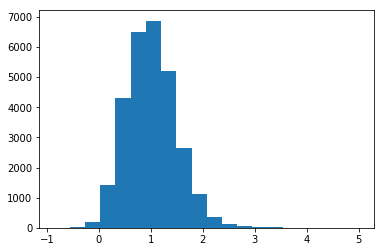

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

h = plt.hist(lin_reg_y_pred, bins=20)

Посчитаем качество модели по метрике **nDCG**

In [18]:
score_lin_reg = get_nDCG_score(
    queries = test_queries_ids, 
    queries_lines_info = queries_lines_info, 
    test_queries_lines_info = test_queries_lines_info, 
    labels_true = y_test, 
    labels_predicted = lin_reg_y_pred
)

score_lin_reg

0.827759744533848

**Давайте теперь решим эту задачу не как регрессию, а как классификацию**

In [43]:
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0, tol=1e-5)
clf.fit(X_train, y_train)

svc_y_pred = clf.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [44]:
score_svc = get_nDCG_score(
    queries = test_queries_ids, 
    queries_lines_info = queries_lines_info, 
    test_queries_lines_info = test_queries_lines_info, 
    labels_true = y_test, 
    labels_predicted = cvs_y_pred
)

score_svc

0.7882826383847911

#### Ранжируем с RandomForestRegressor

In [0]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=20)
regr.fit(X_train, y_train)
rf_y_pred = regr.predict(X_test)


In [39]:
score_rf = get_nDCG_score(
    queries = test_queries_ids, 
    queries_lines_info = queries_lines_info, 
    test_queries_lines_info = test_queries_lines_info, 
    labels_true = y_test, 
    labels_predicted = rf_y_pred
)

score_rf

0.7960207443407159

#### Ранжируем с XGBoost

In [40]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
evallist = [(dtest, 'eval'), (dtrain, 'train')]

param = {'objective': 'multi:softmax', 'num_class': len(set(labels))}

num_round = 20
bst = xgb.train(param, dtrain, num_round, evallist)

xgb_y_pred = bst.predict(dtest)


[0]	eval-merror:0.514755	train-merror:0.461823
[1]	eval-merror:0.503117	train-merror:0.448332
[2]	eval-merror:0.498511	train-merror:0.441244
[3]	eval-merror:0.498234	train-merror:0.435573
[4]	eval-merror:0.488778	train-merror:0.430062
[5]	eval-merror:0.486492	train-merror:0.425473
[6]	eval-merror:0.485799	train-merror:0.419583
[7]	eval-merror:0.481089	train-merror:0.415402
[8]	eval-merror:0.479219	train-merror:0.410243
[9]	eval-merror:0.477833	train-merror:0.405507
[10]	eval-merror:0.477002	train-merror:0.401181
[11]	eval-merror:0.475928	train-merror:0.397863
[12]	eval-merror:0.473885	train-merror:0.393931
[13]	eval-merror:0.474889	train-merror:0.390438
[14]	eval-merror:0.471876	train-merror:0.386799
[15]	eval-merror:0.468066	train-merror:0.382209
[16]	eval-merror:0.467616	train-merror:0.379067
[17]	eval-merror:0.465919	train-merror:0.374609
[18]	eval-merror:0.466646	train-merror:0.370429
[19]	eval-merror:0.464568	train-merror:0.368426


In [41]:
score_xgb = get_nDCG_score(
    queries = test_queries_ids, 
    queries_lines_info = queries_lines_info, 
    test_queries_lines_info = test_queries_lines_info, 
    labels_true = y_test, 
    labels_predicted = xgb_y_pred
)

score_xgb

0.7985753289739121

#### Ранжируем с LightGBM

In [37]:
import lightgbm as lgb

gbm = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=20)
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=5)

gbm_y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

[1]	valid_0's l1: 0.776674	valid_0's l2: 0.847152
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.769093	valid_0's l2: 0.833164
[3]	valid_0's l1: 0.76272	valid_0's l2: 0.820003
[4]	valid_0's l1: 0.757596	valid_0's l2: 0.808119
[5]	valid_0's l1: 0.753474	valid_0's l2: 0.797691
[6]	valid_0's l1: 0.749866	valid_0's l2: 0.787686
[7]	valid_0's l1: 0.746702	valid_0's l2: 0.778751
[8]	valid_0's l1: 0.743786	valid_0's l2: 0.770551
[9]	valid_0's l1: 0.740677	valid_0's l2: 0.762175
[10]	valid_0's l1: 0.737347	valid_0's l2: 0.753882
[11]	valid_0's l1: 0.734331	valid_0's l2: 0.746611
[12]	valid_0's l1: 0.731802	valid_0's l2: 0.740099
[13]	valid_0's l1: 0.729544	valid_0's l2: 0.734666
[14]	valid_0's l1: 0.727144	valid_0's l2: 0.729131
[15]	valid_0's l1: 0.72544	valid_0's l2: 0.724752
[16]	valid_0's l1: 0.722789	valid_0's l2: 0.719204
[17]	valid_0's l1: 0.720326	valid_0's l2: 0.714086
[18]	valid_0's l1: 0.718384	valid_0's l2: 0.709864
[19]	valid_0's l1: 0.716673	vali

In [42]:
score_gbm = get_nDCG_score(
    queries = test_queries_ids, 
    queries_lines_info = queries_lines_info, 
    test_queries_lines_info = test_queries_lines_info, 
    labels_true = y_test, 
    labels_predicted = gbm_y_pred
)

score_gbm

0.8286947727184077

**RESULTS**

In [55]:
scores = {'Linear Regression': score_lin_reg,
         'Linear Classification': score_svc,
         'Random Forest': score_rf,
         'XGBoost': score_xgb,
         'LightGBM': score_gbm}

print("nDCG scores\n")
for key, item in scores.items():
  print(f"{key.ljust(30)}  {item}")

nDCG scores

Linear Regression               0.827759744533848
Linear Classification           0.7882826383847911
Random Forest                   0.7960207443407159
XGBoost                         0.7985753289739121
LightGBM                        0.8286947727184077
